# Machine Learning in Julia, JuliaCon2020

A workshop introducing the machine learning toolbox
[MLJ](https://alan-turing-institute.github.io/MLJ.jl/stable/)

In [1]:
include(joinpath(@__DIR__, "setup.jl"))

 Activating environment at `~/Dropbox/Julia7/MLJ/MachineLearningInJulia2020/Project.toml`


## Part 1: Data representation

> **Goals:**
> 1. Learn how MLJ specifies it's data requirements using "scientific" types
> 2. Understand the options for representing tabular data
> 3. Learn how to inspect and fix the representation of data to meet MLJ requirements

### Scientific types

To help you focus on the intended *purpose* or *interpretation* of
data, MLJ models specify data requirements using *scientific types*,
instead of machine types. An example of a scientific type is
`OrderedFactor`. The other basic "scalar" scientific types are
illustrated below:

![](assets/scitypes.png)

A scientific type is an ordinary Julia type (so it can be used for
method dispatch, for example) but it usually has no instances. The
`scitype` function is used to articulate MLJ's convention about how
different machine types will be interpreted by MLJ models:

In [2]:
using MLJ
scitype(3.141)

Continuous

In [3]:
time = [2.3, 4.5, 4.2, 1.8, 7.1]
scitype(time)

AbstractArray{Continuous,1}

To fix data which MLJ is interpreting incorrectly, we use the
`coerce` method:

In [4]:
height = [185, 153, 163, 114, 180]
scitype(height)

AbstractArray{Count,1}

In [5]:
height = coerce(height, Continuous)

5-element Array{Float64,1}:
 185.0
 153.0
 163.0
 114.0
 180.0

Here's an example of data we would want interpreted as
`OrderedFactor` but isn't:

In [6]:
exam_mark = ["rotten", "great", "bla",  missing, "great"]
scitype(exam_mark)

AbstractArray{Union{Missing, Textual},1}

In [7]:
exam_mark = coerce(exam_mark, OrderedFactor)

┌ Info: Trying to coerce from `Union{Missing, String}` to `OrderedFactor`.
│ Coerced to `Union{Missing,OrderedFactor}` instead.
└ @ MLJScientificTypes /Users/anthony/.julia/packages/MLJScientificTypes/wqfgN/src/convention/coerce.jl:126


5-element CategoricalArray{Union{Missing, String},1,UInt32}:
 "rotten"
 "great"
 "bla"
 missing
 "great"

In [8]:
levels(exam_mark)

3-element Array{String,1}:
 "bla"
 "great"
 "rotten"

Use `levels!` to put the classes in the right order:

In [9]:
levels!(exam_mark, ["rotten", "bla", "great"])
exam_mark[1] < exam_mark[2]

true

Subsampling preserves levels:

In [10]:
levels(exam_mark[1:2])

3-element Array{String,1}:
 "rotten"
 "bla"
 "great"

**Note on binary data.** There is no separate scientific type for binary
data. Binary data is `OrderedFactor{2}` if it has an intrinsic
"true" class (eg, "pass"/"fail") and `Multiclass{2}` otherwise (eg,
"male"/"female").

### Two-dimensional data

Whenever it makes sense, MLJ Models generally expect two-dimensional
data to be *tabular*. All the tabular formats implementing the
[Tables.jl API](https://juliadata.github.io/Tables.jl/stable/) (see
this
[list](https://github.com/JuliaData/Tables.jl/blob/master/INTEGRATIONS.md))
have a scientific type of `Table` and can be used with such models.

The simplest example of a table is a the julia native *column
table*, which is just a named tuple of equal-length vectors:

In [10]:
column_table = (h=height, e=exam_mark, t=time)

(h = [185.0, 153.0, 163.0, 114.0, 180.0],
 e = Union{Missing, CategoricalValue{String,UInt32}}["rotten", "great", "bla", missing, "great"],
 t = [2.3, 4.5, 4.2, 1.8, 7.1],)

In [11]:
scitype(column_table)

Table{Union{AbstractArray{Union{Missing, OrderedFactor{3}},1}, AbstractArray{Continuous,1}}}

Notice the `Table{K}` type parameter `K` encodes the scientific
types of the columns. To see the individual types of columns, we use
the `schema` method instead:

In [12]:
schema(column_table)

┌─────────┬─────────────────────────────────────────────────┬──────────────────────────────────┐
│ _.names │ _.types                                         │ _.scitypes                       │
├─────────┼─────────────────────────────────────────────────┼──────────────────────────────────┤
│ h       │ Float64                                         │ Continuous                       │
│ e       │ Union{Missing, CategoricalValue{String,UInt32}} │ Union{Missing, OrderedFactor{3}} │
│ t       │ Float64                                         │ Continuous                       │
└─────────┴─────────────────────────────────────────────────┴──────────────────────────────────┘
_.nrows = 5


Here are four other examples of tables:

In [13]:
row_table = [(a=1, b=3.4),
             (a=2, b=4.5),
             (a=3, b=5.6)]
schema(row_table)

┌─────────┬─────────┬────────────┐
│ _.names │ _.types │ _.scitypes │
├─────────┼─────────┼────────────┤
│ a       │ Int64   │ Count      │
│ b       │ Float64 │ Continuous │
└─────────┴─────────┴────────────┘
_.nrows = 3


In [15]:
using DataFrames
df = DataFrames.DataFrame(column_table)

,h,e,t
,Float64,Cat…?,Float64
1,185.0,rotten,2.3
2,153.0,great,4.5
3,163.0,bla,4.2
4,114.0,missing,1.8
5,180.0,great,7.1


In [16]:
schema(df)

┌─────────┬─────────────────────────────────────────────────┬──────────────────────────────────┐
│ _.names │ _.types                                         │ _.scitypes                       │
├─────────┼─────────────────────────────────────────────────┼──────────────────────────────────┤
│ h       │ Float64                                         │ Continuous                       │
│ e       │ Union{Missing, CategoricalValue{String,UInt32}} │ Union{Missing, OrderedFactor{3}} │
│ t       │ Float64                                         │ Continuous                       │
└─────────┴─────────────────────────────────────────────────┴──────────────────────────────────┘
_.nrows = 5


In [17]:
using CSV
file = CSV.File(joinpath(DIR, "data", "horse.csv"));
schema(file) # (triggers a file read)

┌─────────────────────────┬─────────┬────────────┐
│ _.names                 │ _.types │ _.scitypes │
├─────────────────────────┼─────────┼────────────┤
│ surgery                 │ Int64   │ Count      │
│ age                     │ Int64   │ Count      │
│ rectal_temperature      │ Float64 │ Continuous │
│ pulse                   │ Int64   │ Count      │
│ respiratory_rate        │ Int64   │ Count      │
│ temperature_extremities │ Int64   │ Count      │
│ mucous_membranes        │ Int64   │ Count      │
│ capillary_refill_time   │ Int64   │ Count      │
│ pain                    │ Int64   │ Count      │
│ peristalsis             │ Int64   │ Count      │
│ abdominal_distension    │ Int64   │ Count      │
│ packed_cell_volume      │ Float64 │ Continuous │
│ total_protein           │ Float64 │ Continuous │
│ outcome                 │ Int64   │ Count      │
│ surgical_lesion         │ Int64   │ Count      │
│ cp_data                 │ Int64   │ Count      │
└─────────────────────────┴────

Most MLJ models do not accept matrix in lieu of a table, but you can
wrap a matrix as a table:

In [18]:
matrix_table = MLJ.table(rand(2,3))
schema(matrix_table)

┌─────────┬─────────┬────────────┐
│ _.names │ _.types │ _.scitypes │
├─────────┼─────────┼────────────┤
│ x1      │ Float64 │ Continuous │
│ x2      │ Float64 │ Continuous │
│ x3      │ Float64 │ Continuous │
└─────────┴─────────┴────────────┘
_.nrows = 2


Under the hood many algorithms convert tabular data to matrices. If
your table is a wrapped matrix like the above, then the compiler
will generally collapse the conversions to a no-op.

### Fixing scientific types in tabular data

To show how we can correct the scientific types of data in tables,
we introduce a cleaned up version of the UCI Horse Colic Data Set
(the cleaning workflow is described
[here](https://alan-turing-institute.github.io/DataScienceTutorials.jl/end-to-end/horse/#dealing_with_missing_values))

In [19]:
using CSV
file = CSV.File(joinpath(DIR, "data", "horse.csv"));
horse = CSV.DataFrame!(file); # convert to data frame without copying columns
first(horse, 4)

,surgery,age,rectal_temperature,pulse,respiratory_rate,temperature_extremities
,Int64,Int64,Float64,Int64,Int64,Int64
1,2,1,38.5,66,66,3
2,1,1,39.2,88,88,3
3,2,1,38.3,40,40,1
4,1,9,39.1,164,164,4


From [the UCI
docs](http://archive.ics.uci.edu/ml/datasets/Horse+Colic) we can
surmise how each variable ought to be interpreted (a step in our
workflow that cannot reliably be left to the computer):

variable                    | scientific type (interpretation)
----------------------------|-----------------------------------
`:surgery`                  | Multiclass
`:age`                      | Multiclass
`:rectal_temperature`       | Continuous
`:pulse`                    | Continuous
`:respiratory_rate`         | Continuous
`:temperature_extremities`  | OrderedFactor
`:mucous_membranes`         | Multiclass
`:capillary_refill_time`    | Multiclass
`:pain`                     | OrderedFactor
`:peristalsis`              | OrderedFactor
`:abdominal_distension`     | OrderedFactor
`:packed_cell_volume`       | Continuous
`:total_protein`            | Continuous
`:outcome`                  | Multiclass
`:surgical_lesion`          | OrderedFactor
`:cp_data`                  | Multiclass

Let's see how MLJ will actually interpret the data, as it is
currently encoded:

In [20]:
schema(horse)

┌─────────────────────────┬─────────┬────────────┐
│ _.names                 │ _.types │ _.scitypes │
├─────────────────────────┼─────────┼────────────┤
│ surgery                 │ Int64   │ Count      │
│ age                     │ Int64   │ Count      │
│ rectal_temperature      │ Float64 │ Continuous │
│ pulse                   │ Int64   │ Count      │
│ respiratory_rate        │ Int64   │ Count      │
│ temperature_extremities │ Int64   │ Count      │
│ mucous_membranes        │ Int64   │ Count      │
│ capillary_refill_time   │ Int64   │ Count      │
│ pain                    │ Int64   │ Count      │
│ peristalsis             │ Int64   │ Count      │
│ abdominal_distension    │ Int64   │ Count      │
│ packed_cell_volume      │ Float64 │ Continuous │
│ total_protein           │ Float64 │ Continuous │
│ outcome                 │ Int64   │ Count      │
│ surgical_lesion         │ Int64   │ Count      │
│ cp_data                 │ Int64   │ Count      │
└─────────────────────────┴────

As a first correction step, we can get MLJ to "guess" the
appropriate fix, using the `autotype` method:

In [20]:
autotype(horse)

Dict{Symbol,Type} with 11 entries:
  :abdominal_distension    => OrderedFactor
  :pain                    => OrderedFactor
  :surgery                 => OrderedFactor
  :mucous_membranes        => OrderedFactor
  :surgical_lesion         => OrderedFactor
  :outcome                 => OrderedFactor
  :capillary_refill_time   => OrderedFactor
  :age                     => OrderedFactor
  :temperature_extremities => OrderedFactor
  :peristalsis             => OrderedFactor
  :cp_data                 => OrderedFactor

Okay, this is not perfect, but a step in the right direction, which
we implement like this:

In [21]:
coerce!(horse, autotype(horse));
schema(horse)

┌─────────────────────────┬────────────────────────────────┬──────────────────┐
│ _.names                 │ _.types                        │ _.scitypes       │
├─────────────────────────┼────────────────────────────────┼──────────────────┤
│ surgery                 │ CategoricalValue{Int64,UInt32} │ OrderedFactor{2} │
│ age                     │ CategoricalValue{Int64,UInt32} │ OrderedFactor{2} │
│ rectal_temperature      │ Float64                        │ Continuous       │
│ pulse                   │ Int64                          │ Count            │
│ respiratory_rate        │ Int64                          │ Count            │
│ temperature_extremities │ CategoricalValue{Int64,UInt32} │ OrderedFactor{4} │
│ mucous_membranes        │ CategoricalValue{Int64,UInt32} │ OrderedFactor{6} │
│ capillary_refill_time   │ CategoricalValue{Int64,UInt32} │ OrderedFactor{3} │
│ pain                    │ CategoricalValue{Int64,UInt32} │ OrderedFactor{5} │
│ peristalsis             │ CategoricalV

All remaining `Count` data should be `Continuous`:

In [22]:
coerce!(horse, Count => Continuous);
schema(horse)

┌─────────────────────────┬────────────────────────────────┬──────────────────┐
│ _.names                 │ _.types                        │ _.scitypes       │
├─────────────────────────┼────────────────────────────────┼──────────────────┤
│ surgery                 │ CategoricalValue{Int64,UInt32} │ OrderedFactor{2} │
│ age                     │ CategoricalValue{Int64,UInt32} │ OrderedFactor{2} │
│ rectal_temperature      │ Float64                        │ Continuous       │
│ pulse                   │ Float64                        │ Continuous       │
│ respiratory_rate        │ Float64                        │ Continuous       │
│ temperature_extremities │ CategoricalValue{Int64,UInt32} │ OrderedFactor{4} │
│ mucous_membranes        │ CategoricalValue{Int64,UInt32} │ OrderedFactor{6} │
│ capillary_refill_time   │ CategoricalValue{Int64,UInt32} │ OrderedFactor{3} │
│ pain                    │ CategoricalValue{Int64,UInt32} │ OrderedFactor{5} │
│ peristalsis             │ CategoricalV

We'll correct the remaining truant entries manually:

In [23]:
coerce!(horse,
        :surgery               => Multiclass,
        :age                   => Multiclass,
        :mucous_membranes      => Multiclass,
        :capillary_refill_time => Multiclass,
        :outcome               => Multiclass,
        :cp_data               => Multiclass);
schema(horse)

┌─────────────────────────┬────────────────────────────────┬──────────────────┐
│ _.names                 │ _.types                        │ _.scitypes       │
├─────────────────────────┼────────────────────────────────┼──────────────────┤
│ surgery                 │ CategoricalValue{Int64,UInt32} │ Multiclass{2}    │
│ age                     │ CategoricalValue{Int64,UInt32} │ Multiclass{2}    │
│ rectal_temperature      │ Float64                        │ Continuous       │
│ pulse                   │ Float64                        │ Continuous       │
│ respiratory_rate        │ Float64                        │ Continuous       │
│ temperature_extremities │ CategoricalValue{Int64,UInt32} │ OrderedFactor{4} │
│ mucous_membranes        │ CategoricalValue{Int64,UInt32} │ Multiclass{6}    │
│ capillary_refill_time   │ CategoricalValue{Int64,UInt32} │ Multiclass{3}    │
│ pain                    │ CategoricalValue{Int64,UInt32} │ OrderedFactor{5} │
│ peristalsis             │ CategoricalV

### Resources for Part 1

- From the MLJ manual:
   - [A preview of data type specification in
  MLJ](https://alan-turing-institute.github.io/MLJ.jl/dev/getting_started/#A-preview-of-data-type-specification-in-MLJ-1)
   - [Data containers and scientific types](https://alan-turing-institute.github.io/MLJ.jl/dev/getting_started/#Data-containers-and-scientific-types-1)
   - [Working with Categorical Data](https://alan-turing-institute.github.io/MLJ.jl/dev/working_with_categorical_data/)
- [Summary](https://alan-turing-institute.github.io/MLJScientificTypes.jl/dev/#Summary-of-the-MLJ-convention-1) of the MLJ convention for representing scientific types
- [MLJScientificTypes.jl](https://alan-turing-institute.github.io/MLJScientificTypes.jl/dev/)
- From Data Science Tutorials:
    - [Data interpretation: Scientific Types](https://alan-turing-institute.github.io/DataScienceTutorials.jl/data/scitype/)
    - [Horse colic data](https://alan-turing-institute.github.io/DataScienceTutorials.jl/end-to-end/horse/)
- [UCI Horse Colic Data Set](http://archive.ics.uci.edu/ml/datasets/Horse+Colic)

### Exercises for Part 1

#### Ex 1

Try to guess how each code snippet below will evaluate:

In [25]:
scitype(42)

Count

In [26]:
questions = ["who", "why", "what", "when"]
scitype(questions)

AbstractArray{Textual,1}

In [27]:
elscitype(questions)

Textual

In [28]:
t = (3.141, 42, "how")
scitype(t)

Tuple{Continuous,Count,Textual}

In [29]:
A = rand(2, 3)
scitype(A)

AbstractArray{Continuous,2}

In [30]:
elscitype(A)

Continuous

In [31]:
using SparseArrays
Asparse = sparse(A)
scitype(Asparse)

AbstractArray{Continuous,2}

In [32]:
using CategoricalArrays
C1 = categorical(A)
scitype(C1)

AbstractArray{Multiclass{6},2}

In [33]:
elscitype(C1)

Multiclass{6}

In [34]:
C2 = categorical(A, ordered=true)
scitype(C2)

AbstractArray{OrderedFactor{6},2}

In [35]:
v = [1, 2, missing, 4]
scitype(v)

AbstractArray{Union{Missing, Count},1}

In [36]:
elscitype(v)

Union{Missing, Count}

In [37]:
scitype(v[1:2])

AbstractArray{Union{Missing, Count},1}

Can you guess at the general behaviour of
`scitype` with respect to tuples, abstract arrays and missing
values? The answers are
[here](https://github.com/alan-turing-institute/ScientificTypes.jl#2-the-scitype-and-scitype-methods)
(ignore "Property 1").

#### Ex 2

Coerce the following vector to make MLJ recognize it as an ordered
factor (with the factors in appropriate order):

In [38]:
quality = ["good", "poor", "poor", "excellent", missing, "good", "excellent"]

7-element Array{Union{Missing, String},1}:
 "good"
 "poor"
 "poor"
 "excellent"
 missing
 "good"
 "excellent"

#### Ex 3 (fixing scitypes in a table)

Fix the scitypes for the [House Prices in King County
data](https://mlr3gallery.mlr-org.com/posts/2020-01-30-house-prices-in-king-county/)
dataset:

In [39]:
file = CSV.File(joinpath(DIR, "data", "house.csv"));
house = CSV.DataFrame!(file); # convert to data frame without copying columns
first(house, 4)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors
,Int64,String,Float64,Int64,Float64,Int64,Int64,Float64
1,7129300520,20141013T000000,221900.0,3,1.0,1180,5650,1.0
2,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0
3,5631500400,20150225T000000,180000.0,2,1.0,770,10000,1.0
4,2487200875,20141209T000000,604000.0,4,3.0,1960,5000,1.0


## Part 2: Selecting, training and evaluating models

The "Hello World!" of machine learning is to classify Fisher's
famous iris data set. This time, we'll grab the data from
[OpenML](https://www.openml.org):

In [24]:
iris = OpenML.load(61); # a row table
iris = DataFrames.DataFrame(iris);
first(iris, 4)

,sepallength,sepalwidth,petallength,petalwidth,class
,Float64,Float64,Float64,Float64,SubStri…
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa


**Goal.** To build and evaluate models for predicting the
`:class` variable, given the four remaining measurement variables.

### Step 1. Inspect and fix scientific types

In [25]:
schema(iris)

┌─────────────┬───────────────────┬────────────┐
│ _.names     │ _.types           │ _.scitypes │
├─────────────┼───────────────────┼────────────┤
│ sepallength │ Float64           │ Continuous │
│ sepalwidth  │ Float64           │ Continuous │
│ petallength │ Float64           │ Continuous │
│ petalwidth  │ Float64           │ Continuous │
│ class       │ SubString{String} │ Textual    │
└─────────────┴───────────────────┴────────────┘
_.nrows = 150


In [26]:
coerce!(iris, :class => Multiclass);
schema(iris)

┌─────────────┬─────────────────────────────────┬───────────────┐
│ _.names     │ _.types                         │ _.scitypes    │
├─────────────┼─────────────────────────────────┼───────────────┤
│ sepallength │ Float64                         │ Continuous    │
│ sepalwidth  │ Float64                         │ Continuous    │
│ petallength │ Float64                         │ Continuous    │
│ petalwidth  │ Float64                         │ Continuous    │
│ class       │ CategoricalValue{String,UInt32} │ Multiclass{3} │
└─────────────┴─────────────────────────────────┴───────────────┘
_.nrows = 150


### Step 2. Split data into input and target parts

Here's how we split the data into target and input features, which
is needed for MLJ supervised models. We randomize the data at the
same time:

In [27]:
y, X = unpack(iris, ==(:class), name->true; rng=123);
scitype(y)

AbstractArray{Multiclass{3},1}

Do `?unpack` to learn more:

In [28]:
@doc unpack

```
t1, t2, ...., tk = unnpack(table, f1, f2, ... fk; wrap_singles=false)
```

Split any Tables.jl compatible `table` into smaller tables (or vectors) `t1, t2, ..., tk` by making selections *without replacement* from the column names defined by the filters `f1`, `f2`, ..., `fk`. A *filter* is any object `f` such that `f(name)` is `true` or `false` for each column `name::Symbol` of `table`.

Whenever a returned table contains a single column, it is converted to a vector unless `wrap_singles=true`.

Scientific type conversions can be optionally specified (note semicolon):

```
unpack(table, t...; wrap_singles=false, col1=>scitype1, col2=>scitype2, ... )
```

### Example

```
julia> table = DataFrame(x=[1,2], y=['a', 'b'], z=[10.0, 20.0], w=[:A, :B])
julia> Z, XY = unpack(table, ==(:z), !=(:w);
               :x=>Continuous, :y=>Multiclass)
julia> XY
2×2 DataFrame
│ Row │ x       │ y            │
│     │ Float64 │ Categorical… │
├─────┼─────────┼──────────────┤
│ 1   │ 1.0     │ 'a'          │
│ 2   │ 2.0     │ 'b'          │

julia> Z
2-element Array{Float64,1}:
 10.0
 20.0
```


### On searching for a model

Here's how to see *all* models (not immediately useful):

In [29]:
kitchen_sink = models()

142-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = ARDRegressor, package_name = ScikitLearn, ... )
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostRegressor, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = AffinityPropagation, package_name = ScikitLearn, ... )
 (name = AgglomerativeClustering, package_name = ScikitLearn, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BaggingRegressor, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, 

Each entry contains metadata for a model whose defining code is not yet loaded:

In [30]:
meta = kitchen_sink[3]

AdaBoost ensemble regression.
→ based on [ScikitLearn](https://github.com/cstjean/ScikitLearn.jl).
→ do `@load AdaBoostRegressor pkg="ScikitLearn"` to use the model.
→ do `?AdaBoostRegressor` for documentation.
(name = "AdaBoostRegressor",
 package_name = "ScikitLearn",
 is_supervised = true,
 docstring = "AdaBoost ensemble regression.\n→ based on [ScikitLearn](https://github.com/cstjean/ScikitLearn.jl).\n→ do `@load AdaBoostRegressor pkg=\"ScikitLearn\"` to use the model.\n→ do `?AdaBoostRegressor` for documentation.",
 hyperparameter_ranges = (nothing, nothing, nothing, nothing, nothing),
 hyperparameter_types = ("Any", "Int64", "Float64", "String", "Any"),
 hyperparameters = (:base_estimator, :n_estimators, :learning_rate, :loss, :random_state),
 implemented_methods = [:clean!, :fit, :fitted_params, :predict],
 is_pure_julia = false,
 is_wrapper = true,
 load_path = "MLJScikitLearnInterface.AdaBoostRegressor",
 package_license = "BSD",
 package_url = "https://github.com/cstjean/Scik

In [31]:
targetscitype = meta.target_scitype

AbstractArray{Continuous,1}

In [32]:
scitype(y) <: targetscitype

false

So this model won't do. Let's  find all pure julia classifiers:

In [33]:
filt(meta) = AbstractVector{Finite} <: meta.target_scitype &&
        meta.is_pure_julia
models(filt)

16-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_name = MLJModels, ... )
 (name = EvoTreeClassifier, package_name = EvoTrees, ... )
 (name = GaussianNBClassifier, package_name = NaiveBayes, ... )
 (name = KNNClassifier, package_name = NearestNeighbors, ... )
 (name = LDA, package_name = 

Find all models with "Classifier" in `name` (or `docstring`):

In [34]:
models("Classifier")

39-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BernoulliNBClassifier, package_name = ScikitLearn, ... )
 (name = ComplementNBClassifier, package_name = ScikitLearn, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_name = MLJModels, ... )
 (name = DummyClassifier, package_name = ScikitLearn, ... )
 (name = EvoTreeClassifier, p

Find all (supervised) models that match my data!

In [35]:
models(matching(X, y))

42-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

### Step 3. Select and instantiate a model

In [36]:
model = @load NeuralNetworkClassifier

NeuralNetworkClassifier(
    builder = Short(
            n_hidden = 0,
            dropout = 0.5,
            σ = NNlib.σ),
    finaliser = NNlib.softmax,
    optimiser = Flux.Optimise.ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}()),
    loss = Flux.crossentropy,
    epochs = 10,
    batch_size = 1,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false) @526

In [37]:
info(model)

A neural network model for making probabilistic predictions of a `Mutliclass` or `OrderedFactor` target, given a table of `Continuous` features. 
→ based on [MLJFlux](https://github.com/alan-turing-institute/MLJFlux.jl).
→ do `@load NeuralNetworkClassifier pkg="MLJFlux"` to use the model.
→ do `?NeuralNetworkClassifier` for documentation.
(name = "NeuralNetworkClassifier",
 package_name = "MLJFlux",
 is_supervised = true,
 docstring = "A neural network model for making probabilistic predictions of a `Mutliclass` or `OrderedFactor` target, given a table of `Continuous` features. \n→ based on [MLJFlux](https://github.com/alan-turing-institute/MLJFlux.jl).\n→ do `@load NeuralNetworkClassifier pkg=\"MLJFlux\"` to use the model.\n→ do `?NeuralNetworkClassifier` for documentation.",
 hyperparameter_ranges = (nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing),
 hyperparameter_types = ("MLJFlux.Short", "typeof(NNlib.softmax)", "Flux.Optimise.ADAM", "typeof(Flux.cr

In MLJ a *model* is just a struct containing hyperparameters, and
that's all. A model does not store *learned* parameters. Models are
mutable:

In [38]:
model.epochs = 12

12

And all models have a key-word constructor that works once `@load`
has been performed:

In [39]:
NeuralNetworkClassifier(epochs=12) == model

true

### On fitting and predicting

In MLJ a model and training/evaluation data are typically bound
together in a machine:

In [40]:
mach = machine(model, X, y)

Machine{NeuralNetworkClassifier{Short,…}} @873 trained 0 times.
  args: 
    1:	Source @208 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @208 ⏎ `AbstractArray{Multiclass{3},1}`


A machine stores *learned* parameters, among other things. We'll
train this machine on 70% of the data and evaluate on a 30% holdout
set. Let's start by dividing all row indices into `train` and `test`
subsets:

In [42]:
train, test = partition(eachindex(y), 0.7)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  96, 97, 98, 99, 100, 101, 102, 103, 104, 105], [106, 107, 108, 109, 110, 111, 112, 113, 114, 115  …  141, 142, 143, 144, 145, 146, 147, 148, 149, 150])

In [43]:
fit!(mach, rows=train, verbosity=2)

┌ Info: Training Machine{NeuralNetworkClassifier{Short,…}} @873.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Loss is 1.232
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.188
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.163
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.144
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.126
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.112
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.1
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.089
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 1.08
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is

Machine{NeuralNetworkClassifier{Short,…}} @873 trained 1 time.
  args: 
    1:	Source @208 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @208 ⏎ `AbstractArray{Multiclass{3},1}`


Machines remember the last set of hyperparameters used during fit,
which, in the case of iterative models, allows them to restart
computations where they left off, when the iteration parameter is
increased:

In [44]:
model.epochs = model.epochs + 4
fit!(mach, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…}} @873.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:318
┌ Info: Loss is 1.011
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.9947
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.9859
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.9749
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95


Machine{NeuralNetworkClassifier{Short,…}} @873 trained 2 times.
  args: 
    1:	Source @208 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @208 ⏎ `AbstractArray{Multiclass{3},1}`


By default, we can also increase `:learning_rate` without a cold restart:

In [45]:
model.epochs = model.epochs + 4
model.optimiser.eta = 10*model.optimiser.eta
fit!(mach, rows=train, verbosity=2)

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…}} @873.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:318
┌ Info: Loss is 0.8565
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.7342
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.659
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95
┌ Info: Loss is 0.6001
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/HxJNU/src/core.jl:95


Machine{NeuralNetworkClassifier{Short,…}} @873 trained 3 times.
  args: 
    1:	Source @208 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @208 ⏎ `AbstractArray{Multiclass{3},1}`


However, change the regularization parameter and training will
restart from scratch:

In [49]:
model.lambda = 0.001
fit!(mach, rows=train, verbosity=2)

┌ Info: Not retraining Machine{NeuralNetworkClassifier{Short,…}} @873. Use `force=true` to force.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:320


Machine{NeuralNetworkClassifier{Short,…}} @873 trained 4 times.
  args: 
    1:	Source @208 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @208 ⏎ `AbstractArray{Multiclass{3},1}`


Let's train silently for a total of 50 epochs, and look at a prediction:

In [50]:
model.epochs = 50
fit!(mach, rows=train)
yhat = predict(mach, X[test,:]); # or predict(mach, rows=test)
yhat[1]

┌ Info: Updating Machine{NeuralNetworkClassifier{Short,…}} @873.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:318
Optimising neural net:100%[=========================] Time: 0:00:00


UnivariateFinite{Multiclass{3}}(Iris-setosa=>0.0771, Iris-versicolor=>0.657, Iris-virginica=>0.266)

What's going on here?

In [63]:
info(model).prediction_type

:probabilistic

**Important**:
- In MLJ, a model that can predict probabilities (and not just point values) will do so by default. (These models have supertype `Proababilistic`, while point-estimate predictors have supertype `Deterministic`.)
- For most probabilistic predictors, the predicted object is a `Distributions.Distribution` object, supporting the `Distributions.jl` [API](https://juliastats.org/Distributions.jl/latest/extends/#Create-a-Distribution-1) for such objects. In particular, the methods `rand`,  `pdf`, `mode`, `median` and `mean` will apply, where appropriate.

So, to obtain the probability of "Iris-virginica" in the first test
prediction, we do

In [64]:
pdf(yhat[1], "Iris-virginica")

0.25201705f0

To get the most likely observation, we do

In [65]:
mode(yhat[1])

CategoricalValue{String,UInt32} "Iris-versicolor"

These can be broadcast over multiple predictions in the usual way:

In [51]:
broadcast(pdf, yhat[1:4], "Iris-versicolor")

4-element Array{Float32,1}:
 0.656501
 0.38027665
 0.008672902
 0.3383447

In [52]:
mode.(yhat[1:4])

4-element CategoricalArray{String,1,UInt32}:
 "Iris-versicolor"
 "Iris-virginica"
 "Iris-setosa"
 "Iris-virginica"

Or, alternatively, you can use the `predict_mode` operation instead
of `predict`:

In [53]:
predict_mode(mach, X[test,:])[1:4] # or predict_mode(mach, rows=test)[1:4]

4-element CategoricalArray{String,1,UInt32}:
 "Iris-versicolor"
 "Iris-virginica"
 "Iris-setosa"
 "Iris-virginica"

For a more conventional matrix of probabilities you can do this:

In [54]:
L = levels(y)
pdf(yhat, L)[1:4, :]

4×3 Array{Float32,2}:
 0.0770982  0.656501   0.266401
 0.0322805  0.380277   0.587443
 0.991327   0.0086729  7.61707f-14
 0.0274174  0.338345   0.634238

However, in a typical MLJ workflow, this is not as useful as you
might imagine. In particular, all probablistic performance measures
in MLJ expect distribution objects in their first slot:

In [55]:
cross_entropy(yhat, y[test]) |> mean

0.34889317f0

To apply a deterministic measure, we first need to obtain point-estimates:

In [56]:
misclassification_rate(mode.(yhat), y[test])

0.06666666666666667

### Step 4. Evaluate the model performance

Naturally, MLJ provides boilerplate code for carrying out a model
evaluation with a lot less fuss. Let's repeat the performance
evaluation above and add an extra measure, `brier_score`:

In [57]:
evaluate!(mach, resampling=Holdout(fraction_train=0.8),
          measures=[cross_entropy, brier_score])

┌──────────────────────────────┬───────────────┬─────────────────┐
│ _.measure                    │ _.measurement │ _.per_fold      │
├──────────────────────────────┼───────────────┼─────────────────┤
│ cross_entropy                │ 0.491         │ Float32[0.491]  │
│ BrierScore{UnivariateFinite} │ -0.264        │ Float32[-0.264] │
└──────────────────────────────┴───────────────┴─────────────────┘
_.per_observation = [[[0.545, 0.544, ..., 0.544]], [[-0.295, -0.295, ..., -0.294]]]


Or applying cross-validation instead:

In [58]:
evaluate!(mach, resampling=CV(nfolds=6),
          measures=[cross_entropy, brier_score])

Evaluating over 6 folds: 100%[=========================] Time: 0:00:04


┌──────────────────────────────┬───────────────┬───────────────────────────────────────────────────────┐
│ _.measure                    │ _.measurement │ _.per_fold                                            │
├──────────────────────────────┼───────────────┼───────────────────────────────────────────────────────┤
│ cross_entropy                │ 0.333         │ Float32[0.36, 0.234, 0.295, 0.486, 0.359, 0.262]      │
│ BrierScore{UnivariateFinite} │ -0.181        │ Float32[-0.2, -0.123, -0.147, -0.269, -0.202, -0.143] │
└──────────────────────────────┴───────────────┴───────────────────────────────────────────────────────┘
_.per_observation = [[[0.421, 0.525, ..., 0.0087], [0.00912, 0.489, ..., 0.00737], [0.0995, 0.465, ..., 0.0368], [0.483, 0.263, ..., 0.484], [0.341, 0.417, ..., 0.651], [0.0018, 0.267, ..., 0.00113]], [[-0.232, -0.256, ..., -0.00015], [-0.000165, -0.251, ..., -0.000108], [-0.0179, -0.25, ..., -0.00255], [-0.241, -0.107, ..., -0.242], [-0.125, -0.18, ..., -0.389], [-6.

Or, Monte-Carlo cross-validation (cross-validation repeated
randomizied folds)

In [59]:
e = evaluate!(mach, resampling=CV(nfolds=6, rng=123),
                repeats=3,
              measures=[cross_entropy, brier_score])

Evaluating over 18 folds: 100%[=========================] Time: 0:00:11


┌──────────────────────────────┬───────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ _.measure                    │ _.measurement │ _.per_fold                                                                                                                                              │
├──────────────────────────────┼───────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ cross_entropy                │ 0.303         │ Float32[0.21, 0.288, 0.311, 0.228, 0.371, 0.327, 0.284, 0.366, 0.339, 0.345, 0.335, 0.286, 0.314, 0.289, 0.258, 0.295, 0.272, 0.33]                     │
│ BrierScore{UnivariateFinite} │ -0.158        │ Float32[-0.114, -0.156, -0.165, -0.0953, -0.219, -0.176, -0.152, -0.199, -0.162, -0.203, -0.188, -0.137, -0.17, -0.136, -0.121, -0.128, -0.

One can access the following properties of the output `e` of an
evaluation: `measure`, `measurement`, `per_fold` (measurement for
each fold) and `per_observation` (measurement per observation, if
reported).

We finally note that you can restrict the rows of observations from
which train and test folds are drawn, by specifying `rows=...`. For
example, imagining the last 30% of target observations are `missing`
you might have a workflow like this:

In [60]:
train, test = partition(eachindex(y), 0.7)
mach = machine(model, X, y)
evaluate!(mach, resampling=CV(nfolds=6),
          measures=[cross_entropy, brier_score],
          rows=train)     # cv estimate, resampling from `train`
fit!(mach, rows=train)    # re-train using all of `train` observations
predict(mach, rows=test); # and predict missing targets

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/resampling.jl:336
Evaluating over 6 folds: 100%[=========================] Time: 0:00:02
┌ Info: Training Machine{NeuralNetworkClassifier{Short,…}} @804.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
Optimising neural net:100%[=========================] Time: 0:00:00


### On learning curves

Since our model is an iterative one, we might want to inspect the
out-of-sample performance as a function of the iteration
parameter. For this we can use the `learning_curve` function (which,
incidentally can be applied to any model hyper-parameter). This
starts by defining a one-dimensional range object for the parameter
(more on this when we discuss tuning in Part 4):

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @590.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Attempting to evaluate 22 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/oLVRR/src/tuned_models.jl:474
Evaluating over 22 metamodels: 100%[=========================] Time: 0:00:01


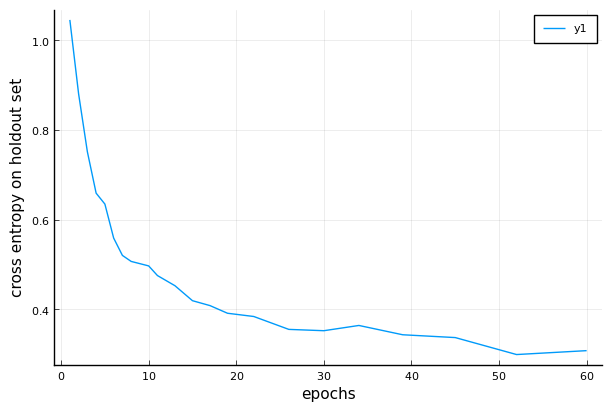

In [61]:
r = range(model, :epochs, lower=1, upper=60, scale=:log)
curve = learning_curve(mach,
                       range=r,
                       resampling=Holdout(fraction_train=0.7), # (default)
                       measure=cross_entropy)

using Plots
pyplot()
plt=plot(curve.parameter_values, curve.measurements)
xlabel!(plt, "epochs")
ylabel!(plt, "cross entropy on holdout set")
savefig("iris_learning_curve.png")

### Exercises for Part 2

#### Ex 4

(a) Identify all supervised MLJ models that can be applied (without
type coercion or one-hot encoding) to a supervised learning problem
with input features `X4` and target `y4` defined below:

In [77]:
import Distributions
poisson = Distributions.Poisson

age = 18 .+ 60*rand(10);
salary = coerce(rand([:small, :big, :huge], 10), OrderedFactor);
levels!(salary, [:small, :big, :huge]);
X4 = DataFrames.DataFrame(age=age, salary=salary)

n_devices(salary) = salary > :small ? rand(poisson(1.3)) : rand(poisson(2.9))
y4 = [n_devices(row.salary) for row in eachrow(X4)]

10-element Array{Int64,1}:
 1
 4
 2
 1
 1
 0
 2
 3
 3
 4

(b) What models can be applied if you coerce the salary to a
`Continuous` scitype?

#### Ex 5 (unpack)

After evaluating the following ...

In [78]:
data = (a = [1, 2, 3, 4],
     b = rand(4),
     c = rand(4),
     d = coerce(["male", "female", "female", "male"], OrderedFactor));
pretty(data)

using Tables
y, X, w = unpack(data, ==(:a),
                 name -> elscitype(Tables.getcolumn(data, name)) == Continuous,
                 name -> true)

┌───────┬───────────────────────┬────────────────────┬─────────────────────────────────┐
│ a     │ b                     │ c                  │ d                               │
│ Int64 │ Float64               │ Float64            │ CategoricalValue{String,UInt32} │
│ Count │ Continuous            │ Continuous         │ OrderedFactor{2}                │
├───────┼───────────────────────┼────────────────────┼─────────────────────────────────┤
│ 1     │ 0.3438212558886624    │ 0.6935640305810773 │ male                            │
│ 2     │ 0.2837422634821589    │ 0.8069806711377399 │ female                          │
│ 3     │ 0.0038286450524995796 │ 0.8437662047218633 │ female                          │
│ 4     │ 0.9038581683696969    │ 0.927215259780952  │ male                            │
└───────┴───────────────────────┴────────────────────┴─────────────────────────────────┘


([1, 2, 3, 4], (b = [0.3438212558886624, 0.2837422634821589, 0.0038286450524995796, 0.9038581683696969], c = [0.6935640305810773, 0.8069806711377399, 0.8437662047218633, 0.927215259780952]), CategoricalValue{String,UInt32}["male", "female", "female", "male"])

...attempt to guess the evaluations of the following:

In [79]:
y

4-element Array{Int64,1}:
 1
 2
 3
 4

In [80]:
pretty(X)

┌───────────────────────┬────────────────────┐
│ b                     │ c                  │
│ Float64               │ Float64            │
│ Continuous            │ Continuous         │
├───────────────────────┼────────────────────┤
│ 0.3438212558886624    │ 0.6935640305810773 │
│ 0.2837422634821589    │ 0.8069806711377399 │
│ 0.0038286450524995796 │ 0.8437662047218633 │
│ 0.9038581683696969    │ 0.927215259780952  │
└───────────────────────┴────────────────────┘


In [81]:
w

4-element CategoricalArray{String,1,UInt32}:
 "male"
 "female"
 "female"
 "male"

#### Ex 6 (horse data)

(a) Suppose we want to use predict the `:outcome` variable in the
Horse Colic study introduced in Part 1, based on the remaining
variables that are `Continuous` (one-hot encoding categorical
variables is discussed later in Part 3) *while ignoring the others*.
Extract from the `horse` data set (defined in Part 1) appropriate
input features `X` and target variable `y`? (Do not, however,
randomize the obserations.)

(b) Create a 70:30 `train`/`test` split of the data and train a
`KNNClassifier` model on the `train` data, using `K = 20` and
default values for the other hyper-parameters. (Although one would
normally standardize (whiten) the continuous features for this
model, do not do so here.) After training:

- (i) Evaluate the `cross_entropy` performance on the `test`
  observations.

- &star;(ii) In how many `test` observations does the predicted
  probablility of the observed class exceed 50%?

- &star;(iii) Find the `misclassification_rate` in the `test`
  set. (*Hint.* As this measure is deterministic, you will either
  need to broadcast `mode` or use `predict_mode` instead of
  `predict`.)

(c) Instead use a `RandomForestClassifier` model from the
    `DecisionTree` package and:

- (i) Generate an appropriate learning curve to
  convince yourself that out-of-sample estimates of the
  `cross_entropy` loss do not substatially improve for `n_trees >
  50`. Use default values for all other hyper-parameters, and feel
  free to use all available data to generate the curve.

- (ii) Fix `n_trees=90` and use `evaluate!` to obtain a 9-fold
  cross-validation estimate of the `cross_entropy`, restricting
  sub-sampling to the `train` observations.

- (iii) Now use *all* available data but set
  `resampling=Holdout(fraction_train=0.7)` to obtain a score you can
  compare with the `KNNClassifier` in part (b)(iii). Which model is
  better?

## Solutions to exercises

#### Ex 2 solution

In [82]:
quality = coerce(quality, OrderedFactor);
levels!(quality, ["poor", "good", "excellent"]);
elscitype(quality)

┌ Info: Trying to coerce from `Union{Missing, String}` to `OrderedFactor`.
│ Coerced to `Union{Missing,OrderedFactor}` instead.
└ @ MLJScientificTypes /Users/anthony/.julia/packages/MLJScientificTypes/wqfgN/src/convention/coerce.jl:126


Union{Missing, OrderedFactor{3}}

#### Ex 3 solution

TODO

#### Ex 4 solution

4(a)

There are *no* models that apply immediately:

In [83]:
models(matching(X4, y4))

0-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}

4(b)

In [84]:
y4 = coerce(y4, Continuous);
models(matching(X4, y4))

4-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = ConstantRegressor, package_name = MLJModels, ... )
 (name = DecisionTreeRegressor, package_name = DecisionTree, ... )
 (name = DeterministicConstantRegressor, package_name = MLJModels, ... )
 (name = RandomForestRegressor, package_name = DecisionTree, ... )

#### Ex 6 solution

6(a)

In [85]:
y, X = unpack(horse,
              ==(:outcome),
              name -> elscitype(Tables.getcolumn(horse, name)) == Continuous);

6(b)(i)

In [86]:
model = @load KNNClassifier
model.K = 20
mach = machine(model, X, y)
fit!(mach, rows=train)
yhat = predict(mach, rows=test) # or predict(mach, X[test,:]);
err = cross_entropy(yhat, y[test]) |> mean

┌ Info: Training Machine{KNNClassifier} @961.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317


1.5025623288812562

6(b)(ii)

The predicted probabilities of the actual observations in the test
are given by

In [87]:
p = broadcast(pdf, yhat, y[test]);

The number of times this probability exceeds 50% is:

In [88]:
n50 = filter(x -> x > 0.5, p) |> length

26

Or, as a proportion:

In [89]:
n50/length(test)

0.5777777777777777

6(c)(iii)

In [90]:
misclassification_rate(mode.(yhat), y[test])

0.3333333333333333

6(c)(i)

In [91]:
model = @load RandomForestClassifier pkg=DecisionTree
mach = machine(model, X, y)
evaluate!(mach, resampling=CV(nfolds=6), measure=cross_entropy)

r = range(model, :n_trees, lower=10, upper=70, scale=:log)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


MLJBase.NumericRange(Int64, :n_trees, ... )

Since random forests are inherently randomized, we generate multiple
curves:

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @376.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Attempting to evaluate 29 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/oLVRR/src/tuned_models.jl:474
Evaluating over 29 metamodels: 100%[=========================] Time: 0:00:00
┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @244.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Attempting to evaluate 29 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/oLVRR/src/tuned_models.jl:474
Evaluating over 29 metamodels: 100%[=========================] Time: 0:00:00
┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @431.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/machines.jl:317
┌ Info: Attempting to evaluate 29 models.
└ @ MLJTuning /Users/anthony/.julia/packages/MLJTuning/oLVRR/src/tuned_models.jl:474
Evaluating over 29 metamodels: 100%[======

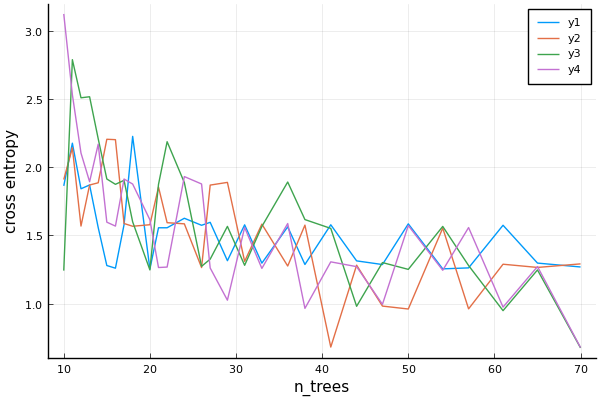

In [92]:
plt = plot()
for i in 1:4
    curve = learning_curve(mach,
                           range=r,
                           resampling=Holdout(),
                           measure=cross_entropy)
    plt=plot!(curve.parameter_values, curve.measurements)
end
xlabel!(plt, "n_trees")
ylabel!(plt, "cross entropy")

6(c)(ii)

In [93]:
evaluate!(mach, resampling=CV(nfolds=9),
                measure=cross_entropy,
                rows=train).measurement[1]

model.n_trees = 90

┌ Info: Creating subsamples from a subset of all rows. 
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/r3heT/src/resampling.jl:336
Evaluating over 9 folds: 100%[=========================] Time: 0:00:00


90

6(c)(iii)

In [94]:
err_forest = evaluate!(mach, resampling=Holdout(),
                       measure=cross_entropy).measurement[1]

1.563353844275659

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*